# Introduction to Machine Learning
### Andreas Muller and Sarah Guido
## Ch. 2 Supervised Learning

# Decision Trees and Random Forests
* Building decision tree until all leaves are pure leads to models that are complex, overfit
* Presence of pure leaves means the tree is 100% accurate on the training set
* Each data point in training set is in a leaf that has the correct majority class

## Strategies to Prevent Overfitting
### Pre-pruning: 
* Stopping the creation of tree early
* Limiting the maximum depth of the tree, or limiting maximum number of leaves
* Requiring a minimum number of points in a node to keep splitting it

### Pruning (post-pruning): 
* Building tree and then removing or collapsing nodes with little info

## Classification with Decision Trees in Scikit Learn
* Implemented in the DecisionTreeRegressor or DecisionTreeClassifier
* scikit-learn only does `pre-pruning`, but not post-pruning
* Import standard packages

In [1]:
import sklearn
import mglearn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image, display
from sklearn.tree import DecisionTreeClassifier

## Import Dataset: WI Breast Cancer Study

In [2]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
print(cancer.keys())

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])


In [3]:
print(cancer['target_names'])

['malignant' 'benign']


In [4]:
print(cancer['feature_names'])

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [5]:
type(cancer)

sklearn.datasets.base.Bunch

In [6]:
cancer.data.shape

(569, 30)

In [ ]:
# Add target_df to cancer_df, and export to CSV file
#cancer_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
#target_df = pd.DataFrame(cancer.target)
#cancer_df["target"] = target_df[0]

#cancer_df.to_csv("cancer_data.csv", sep=',', encoding='utf-8')
#cancer_df.tail()

## Classification with Cancer Dataset
* Split dataset into TRAIN and TEST sets
* Build model using default setting that fully develops tree until all leaves are pure
* Fix the `random_state` in the tree, for breaking ties internally
* Evaluate the tree model using score() method

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)

In [8]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [9]:
print("Accuracy on the training: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on the test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on the training: 1.000
Accuracy on the test set: 0.937


## Pruning
* Training set accuracy is 100% because leaves are pure
* Trees can become arbitrarily deep, complex, if depth of the tree is not limmited
* Unpruned trees are proone to overfitting and not generalizing well to new data

### Set max_depth=4
* Tree depth is limited to 4 branches
* Limiting depth of the tree decreases overfitting 
* Results in lower accuracy on training set, but improvement on test set

In [10]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on the training: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on the test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on the training: 0.988
Accuracy on the test set: 0.951


## Analyzing Decision Tree
* Visualize the tree using `export_graphviz` function from trees module
* Set an option to color the nodes to reflect majority class in each node
* First, need to install graphviz at terminal using `brew install graphviz`

In [11]:
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"],
                feature_names=cancer.feature_names, impurity=False, filled=True)

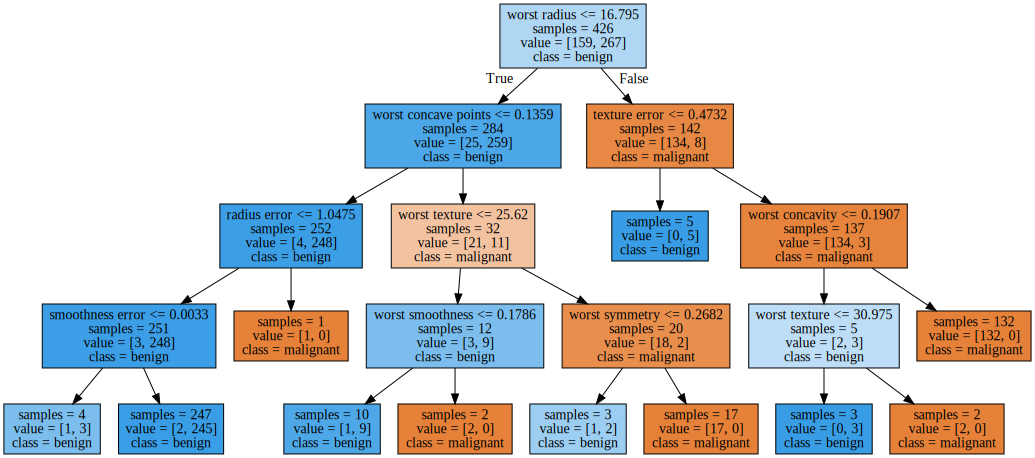

In [16]:
from IPython.display import display

import graphviz

with open('tree.dot') as f:
    dot_graph = f.read()

display(graphviz.Source(dot_graph))

### Visualization of Decision Tree for Breast Cancer Dataset
* Even with tree with depth of only 4, tree becomes complex; deeper trees even harder to grasp
* Follow paths that most of data take: number of `samples` per node, and `value` (samples per class)

## Feature Importance in Trees
* Reates how important each feature is for the decision a tree makes
* Values range from `0 = "Not at all"`, to `1 = perfectly predicts target"`
* Feature importances always sum to a total of 1. 

In [17]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.01019737  0.04839825  0.          0.
  0.0024156   0.          0.          0.          0.          0.
  0.72682851  0.0458159   0.          0.          0.0141577   0.          0.018188
  0.1221132   0.01188548  0.        ]


### Visualize Feature Importancee
* Similar to how we visualized coefficients in linear model
* Feature used in top split ("worst radius") is most important feature
* However, features with low importance may be redundant with another feature that encodes same information

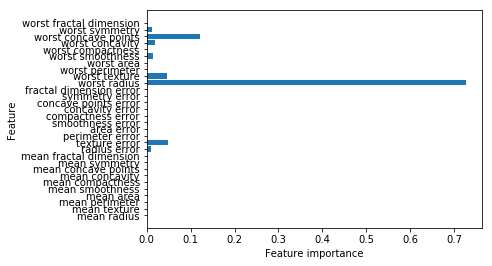

In [23]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances_cancer(tree)

# Building Random Forests
* To build a random forests model, need to decide how many trees to build: `n_estimators` parameter
* Trees are built completely independently of each other, based on "bootstrap" samples of dataset: `n_samples`
* Algorithm randomly selects subset of features, number of features determined by `max_features` paramter
* Each node of tree makes decision involving different subset of features

### Bootstrap Sampling and Subsets of Features
* Each decision tree in random forest is built on slightly different dataset
* Each split in each tree operates on different subset of features

## Critical Parameter: max_features
* If `max_features` set to `n_features`, each split can look at all features inthe dataset, no randomness in selection
* High `max_features` means the trees in a random forest will be quite similar
* Low `max_feature` means trees in random forest will be quite different

### Prediction with Random Forests
* Algorithm first makes prediction for every tree in the forest
* For regression, final prediction is based on average of results
* For classification, a "soft voting" is applied, probabilities for all trees are then averaged, and class with highest probability is predicted

## Apply Random Forests with Cancer dataset
* Split data into train and test sets; build random forest with 100 trees
* Random forest gives better accuracy than linear models of single decision tree, without tuning any parameters

In [26]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=0)

forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 0.998
Accuracy on test set: 0.944


### Features Importance for Random Forest
* Computed by aggregating the feature importances over the trees in the forest
* Feature importances provided by Random Forest are more reliable than provided by single tree
* Many more features have non-zero importance than single tree, chooses similar features

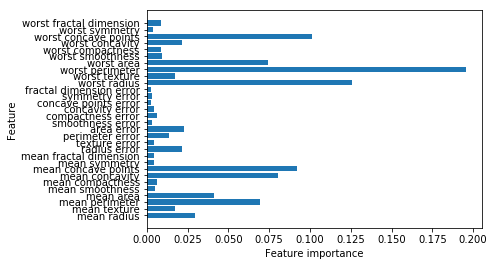

In [27]:
plot_feature_importances_cancer(forest)

### Strengths, weaknesses, parameters
* Most widely used ML method, very powerful, work well without heavy parameter tuning, without scaling of data
* Very difficult to interpret tens of hundreds of trees, random forests are deeper than single decision trees
* Random forests do NOT perform well with very high-dimensional, spare data, such as text data
* `max_features` paramter determines how random each tree is; smaller `max_features` reduces overfitting

## Gradient Boosted Classifier Trees
* Works by building trees in a serial manner, where each tree tries to correct for mistakes of previous ones
* Main idea: combine many simple models, shallow trees ('weak learners'); more tree iteratively improves performance

### Parameters
* Pre-pruning, and number of trees in ensemble
* `learning_rate` parameter controls how strongly each tree tries to correct mistakes of previous trees
* Add more trees to model with `n_estimators`, increases model complexity

### GradientBoostingClassifier on Breast Cancer dataset
* With 100 trees, of maximum depth 3, and learning rate of 0.1

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0, n_estimators=100, max_depth=3, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.995
Accuracy on test set: 0.944


## Feature Importance
* With 100 trees, cannot inspect them all, even if maximum depth is only 1 

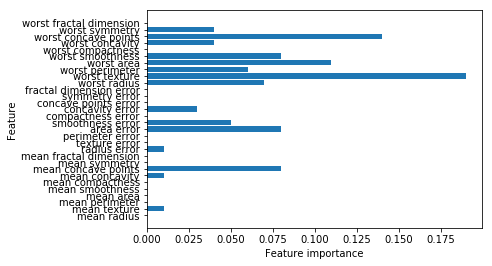

In [31]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)